**Data Source:** Pleschberger, Martin, Zernig, Anja, & Kaestner, Andre. (2020). Equipment Sensor Data from Semiconductor Frontend Production (Version 1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4282611

In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 100
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sensors_1_to_24 = pd.read_csv('equipment1.csv', sep=';')
sensors_25_to_56 = pd.read_csv('equipment2.csv', sep=';')
response = pd.read_csv('response.csv', sep=';')

In [3]:
sensors_1_to_24.lot = sensors_1_to_24.lot.str.replace('lot', '').astype('int64')
sensors_1_to_24.timestamp = sensors_1_to_24.timestamp.str.replace('timestamp_', '').astype('int64')

sensors_25_to_56.lot = sensors_25_to_56.lot.str.replace('lot', '').astype('int64')
sensors_25_to_56.timestamp = sensors_25_to_56.timestamp.str.replace('timestamp_', '').astype('int64')

In [4]:
grouped_data_1_to_24 = sensors_1_to_24.groupby(['lot', 'wafer']).mean().sort_values('lot')
grouped_data_25_to_56 = sensors_25_to_56.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [5]:
response['lot'] = response['lot'].str.replace('lot', '').astype('int64')
response['class'] = response['class'].replace(['good', 'bad'], [1, 0])
grouped_response = response.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [6]:
print(len(grouped_response.index) - len(grouped_data_25_to_56.index))
print(len(grouped_response.index) - len(grouped_data_1_to_24.index))

0
348


In [7]:
sensor_data = grouped_data_1_to_24.join(grouped_data_25_to_56, how='outer', lsuffix='_1_to_24', rsuffix='_25_to_56')
data = sensor_data.join(grouped_response, how='outer')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1319 entries, (2, 1) to (103, 25)
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_1_to_24   971 non-null    float64
 1   sensor_1            971 non-null    float64
 2   sensor_2            971 non-null    float64
 3   sensor_3            971 non-null    float64
 4   sensor_4            971 non-null    float64
 5   sensor_5            971 non-null    float64
 6   sensor_6            971 non-null    float64
 7   sensor_7            971 non-null    float64
 8   sensor_8            971 non-null    float64
 9   sensor_9            971 non-null    float64
 10  sensor_10           971 non-null    float64
 11  sensor_11           971 non-null    float64
 12  sensor_12           971 non-null    float64
 13  sensor_13           971 non-null    float64
 14  sensor_14           971 non-null    float64
 15  sensor_15           971 non-null    float64
 

In [9]:
data.head()

timestamp_1_to_24  sensor_1  sensor_2   sensor_3   sensor_4  \
lot wafer                                                                
2   1                   87.5  5.231203  5.176705  13.251176  42.618787   
    2                   87.5  5.196315  5.142614  13.666808  43.419169   
    3                   87.5  5.161432  5.255114  13.243853  42.981363   
    4                   87.5  5.175509  5.294318  13.671360  43.151993   
    5                   87.5  5.201729  5.127273  13.332878  43.262745   

            sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  \
lot wafer                                                                 
2   1      43.066761       0.0  8.505448       0.0  7.267045  11.703011   
    2      43.147443       0.0  9.167583       0.0  7.607955  11.960227   
    3      42.650795       0.0  8.666924       0.0  7.295455  11.563523   
    4      42.904432       0.0  9.621476       0.0  7.613636  12.191591   
    5      43.001705       0.0  9.275963       0.0  7.335227  11.556989   

           sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  \
lot wafer                                                                     
2   1      12.346591        0.0   0.266298   0.266298   0.266298   0.266298   
    2      12.761364        0.0   0.266162   0.266162   0.266162   0.266162   
    3      12.551136        0.0   0.266903   0.266903   0.266903   0.266903   
    4      13.215909        0.0   0.267062   0.267062   0.267062   0.267062   
    5      12.568182        0.0   0.266392   0.266392   0.266392   0.266392   

           sensor_17   sensor_18   sensor_19  sensor_20  sensor_21  \
lot wafer                                                            
2   1       6.164773  398.018165  126.723761   9.778409  79.217614   
    2       6.363636  408.363824  201.201568  10.329545  88.847159   
    3       6.164773  398.137699  113.195898   9.727273  79.772727   
    4       6.363636  408.062517  179.183085  10.164773  88.403409   
    5       6.204545  398.231636  107.544619   9.715909  80.952273   

            sensor_22   sensor_23  sensor_24  timestamp_25_to_56  sensor_25  \
lot wafer                                                                     
2   1      208.905500  467.232955   0.983864                87.5   0.001495   
    2      208.953966  467.204545   1.017557                87.5   0.001500   
    3      212.313545  477.465909   0.987557                87.5   0.001505   
    4      212.313250  477.437500   1.015966                87.5   0.001509   
    5      208.906159  467.227273   1.011364                87.5   0.001499   

            sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  \
lot wafer                                                                      
2   1      232.694903    60.1875     6.6875        0.0  21.821591  11.296246   
    2      245.951321    63.5625     7.0625        0.0  22.105284  10.849002   
    3      243.975941    63.0000     7.0000        0.0  21.821420  11.063067   
    4      246.357599    63.5625     7.0625        0.0  22.105057  10.858582   
    5      246.561347    63.5625     7.0625        0.0  22.104545  11.069689   

           sensor_32  sensor_33  sensor_34  sensor_35  sensor_36  sensor_37  \
lot wafer                                                                     
2   1      79.692877        0.0   0.001977  37.624962        0.0  21.595660   
    2      80.814970        0.0   0.001973  39.854000        0.0  22.763340   
    3      80.783452        0.0   0.001954  39.408217        0.0  22.018238   
    4      80.050300        0.0   0.001954  39.754566        0.0  21.757269   
    5      80.733545        0.0   0.001977  39.854118        0.0  22.053265   

           sensor_38  sensor_39   sensor_40  sensor_41   sensor_42  \
lot wafer                                                            
2   1      44.118530  42.609528  189.509110   1.660068  120.094154   
    2      45.344954  43.932713  196.95882

In [10]:
data.describe()

,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class
count,971.0,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,1319.0,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1.319000e+03,1319.000000,1319.000000,1319.000000
mean,87.5,4.067866,4.121005,37.679053,32.396468,32.348691,0.137369,10.663262,0.962059,7.350330,11.727677,12.926142,0.296606,0.263935,0.263935,0.263554,0.263539,6.213089,394.627237,106.444442,13.367926,313.857465,210.804377,469.115216,0.951073,87.5,0.001403,154.539367,61.388629,7.010709,0.001700,20.873311,10.445576,75.038648,0.000202,0.001861,38.326207,0.000207,23.872753,41.882245,39.580997,189.514677,2.650611,122.333376,124.302022,1.040673,453.448962,30.591545,783.977135,15.756765,176.676296,30.255056,175.282816,123.584465,198.086621,195.264637,5.419853e-01,0.617882,0.610433,0.799848
std,0.0,1.198389,1.183829,26.205390,11.573819,11.528880,0.559614,1.422817,0.689784,0.230095,0.337128,0.458412,1.098912,0.004763,0.004763,0.005090,0.005104,0.151641,10.060235,25.488229,3.742843,454.613894,3.732648,12.521195,0.081925,0.0,0.000049,79.418785,4.539808,0.561165,0.001149,0.716157,0.336480,2.559284,0.007353,0.000053,2.818333,0.007509,1.999914,1.827950,1.694330,10.079443,0.658755,9.044779,9.225132,0.090416,226.612973,1.590658,407.874725,0.600415,4.661447,1.611555,4.716476,9.136877,197.519613,196.568782,1.158684e-01,0.045494,0.442395,0.400265
min,87.5,2.212025,2.727273,13.161544,19.433870,19.431818,0.000000,8.397660,0.000000,6.937500,10.993409,12.090909,0.000000,0.254773,0.254773,0.253977,0.253977,5.965909,377.069847,73.119232,9.596591,0.250000,202.351875,433.028409,0.846875,87.5,0.001222,4.216210,50.625000,5.585227,0.000000,18.742386,9.322899,64.197888,0.000000,0.001696,31.725676,0.000000,19.200304,36.798038,35.246175,161.202755,0.962720,101.008813,102.426010,0.892045,14.255641,26.636136,72.361073,13.941364,158.500000,25.422727,153.122727,102.367403,0.000003,0.000002,2.907170e-07,0.511534,0.360000,0.000000
25%,87.5,2.812509,2.812500,13.588334,19.822606,19.857955,0.000000,9.351565,0.557398,7.153409,11.474176,12.522727,0.000000,0.260739,0.260739,0.259886,0.259830,6.085227,386.319659,95.938347,9.840909,79.354545,208.896551,455.767045,0.863750,87.5,0.001373,103.390709,60.187500,6.778409,0.000000,20.446023,10.218000,73.090327,0.000000,0.001817,37.687526,0.000000,22.598349,40.602276,38.329930,182.127009,2.208014,119.956132,121.636887,1.011364,295.523954,29.430682,452.774723,15.326705,173.210227,29.096591,172.103693,121.243535,0.000007,0.000007,4.892623e-01,0.607131,0.396000,1.000000
50%,87.5,5.119721,5.130682,13.924515,42.540133,42.656080,0.000000,9.926390,0.669504,7.284091,11.634716,12.875000,0.000000,0.266520,0.266520,0.266511,0.266511,6.164773,395.671869,101.606156,10.159091,87.622159,212.137693,468.323864,1.011307,87.5,0.001403,147.633078,61.312500,6.937500,0.002045,21.013977,10.463086,75.162172,0.000000,0.001860,38.053884,0.000000,24.341112,41.898304,39.577587,190.54430

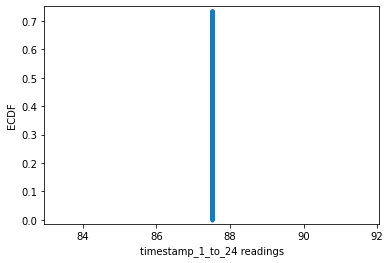

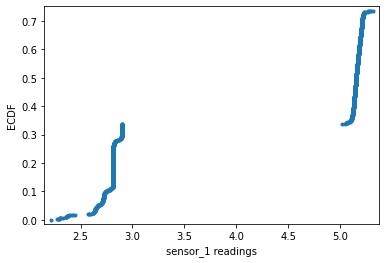

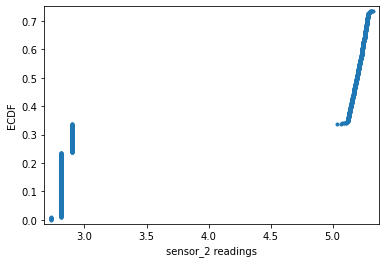

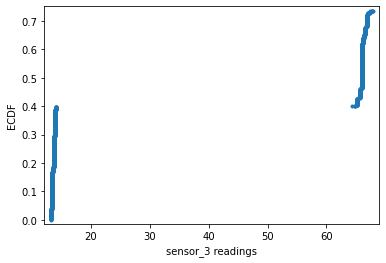

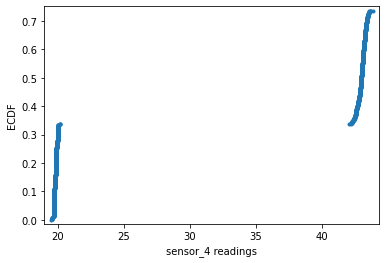

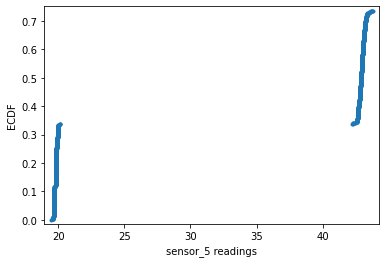

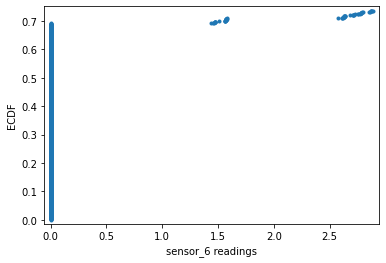

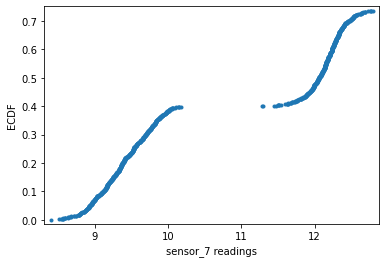

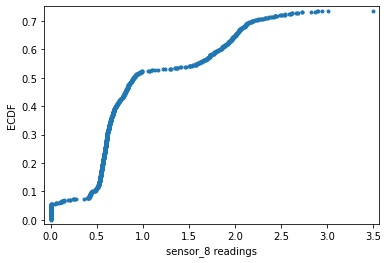

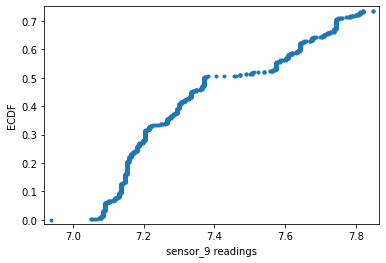

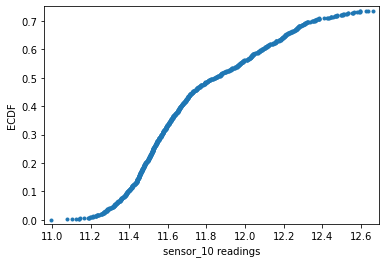

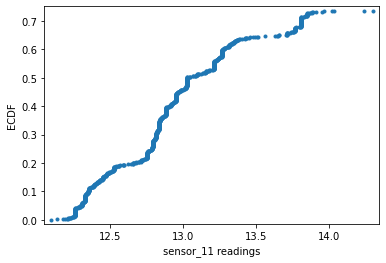

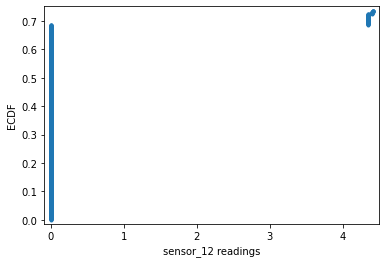

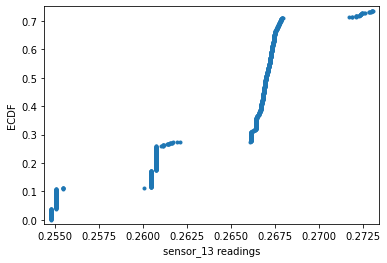

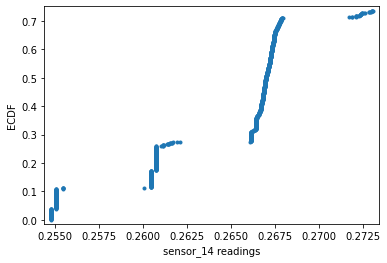

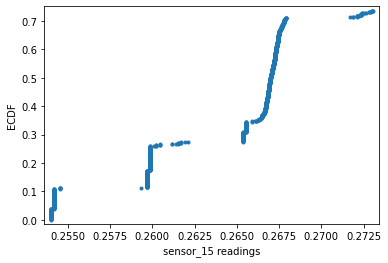

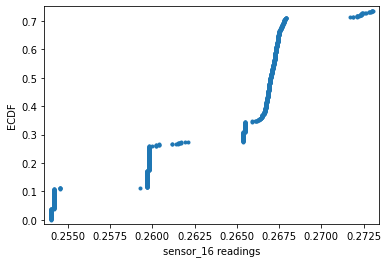

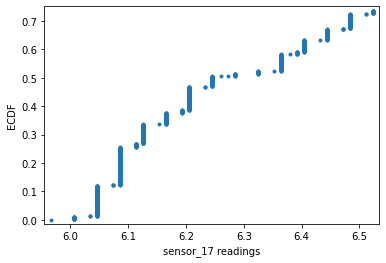

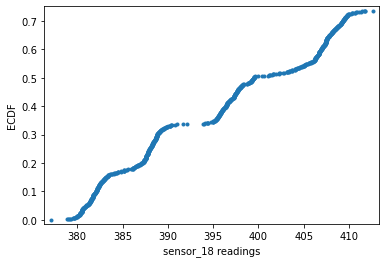

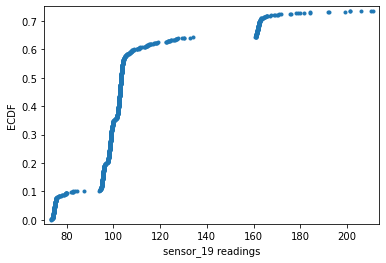

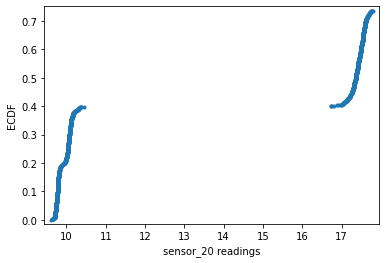

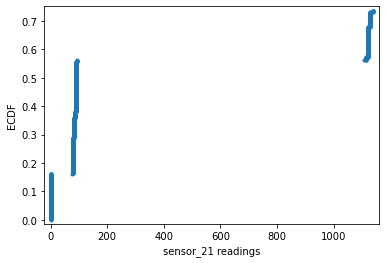

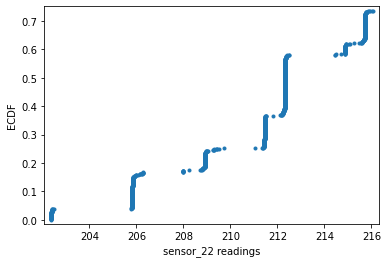

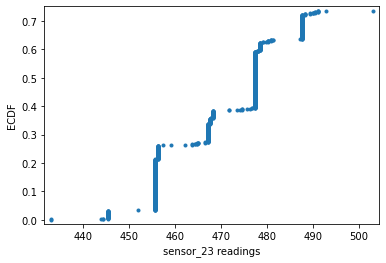

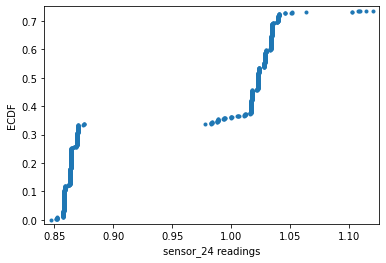

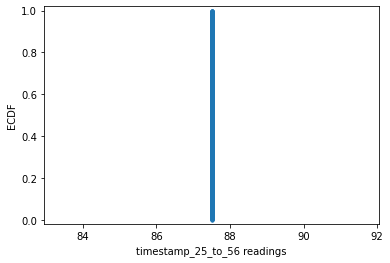

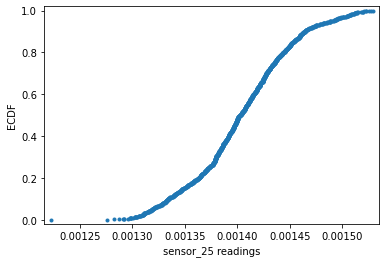

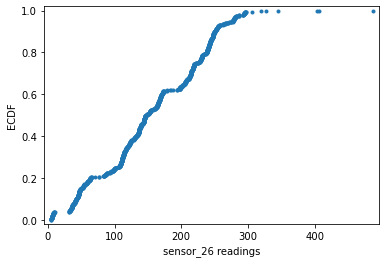

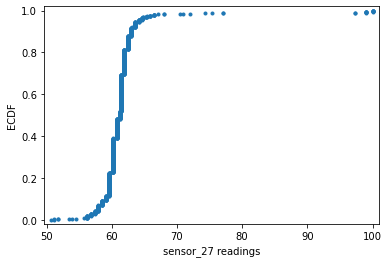

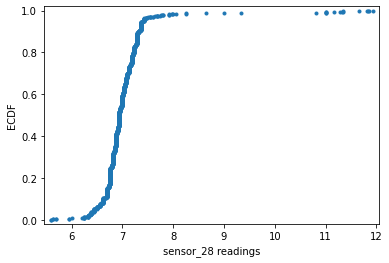

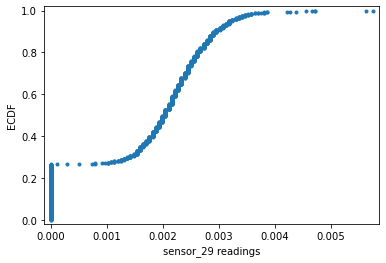

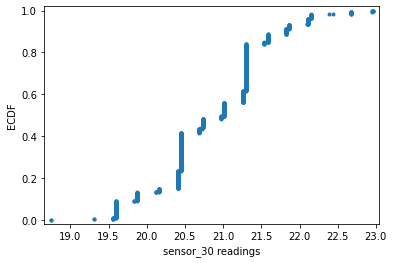

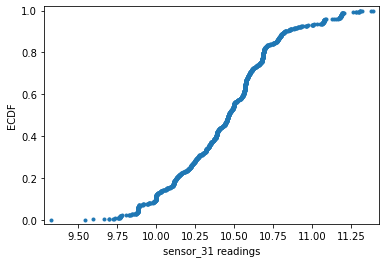

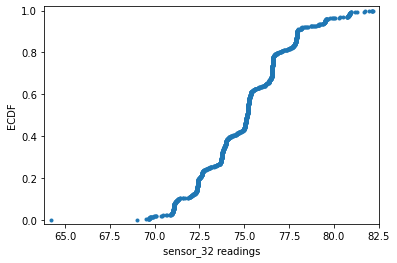

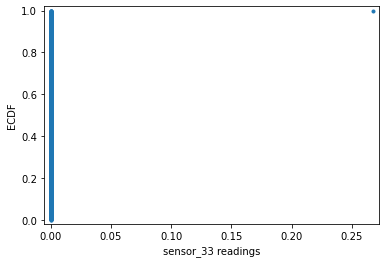

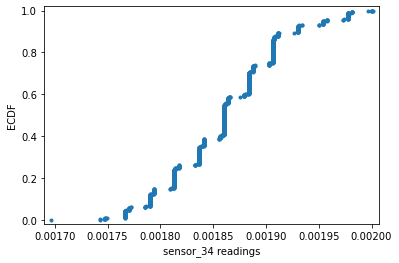

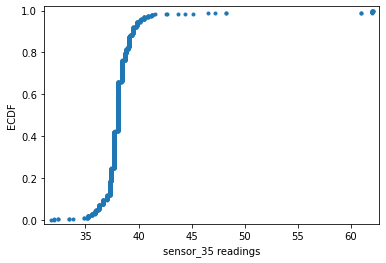

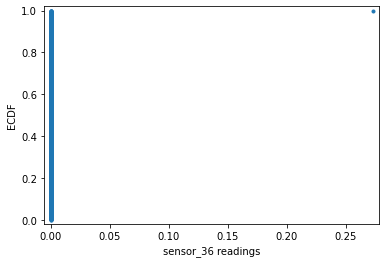

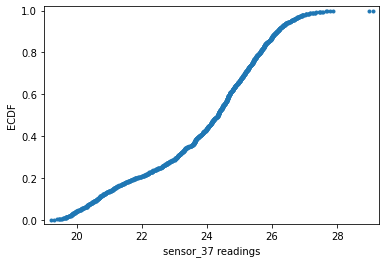

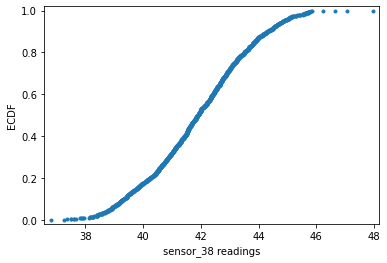

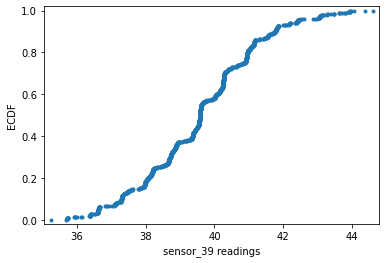

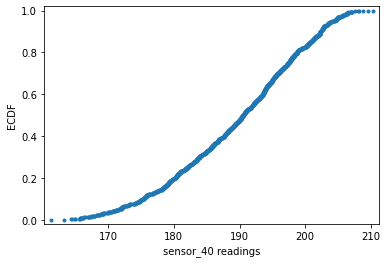

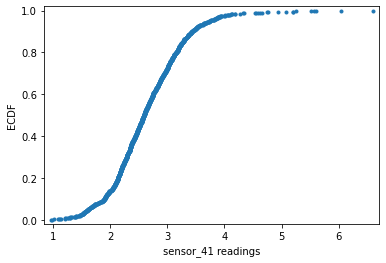

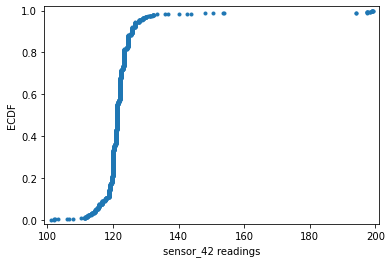

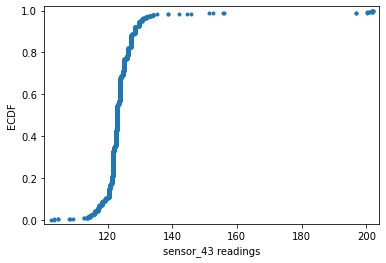

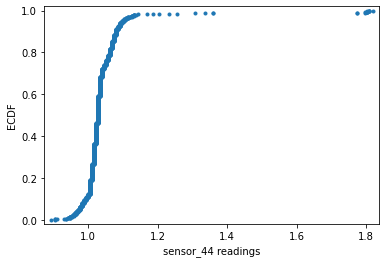

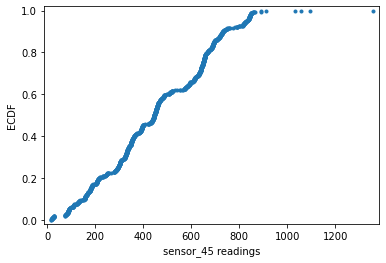

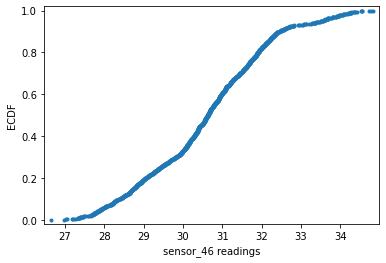

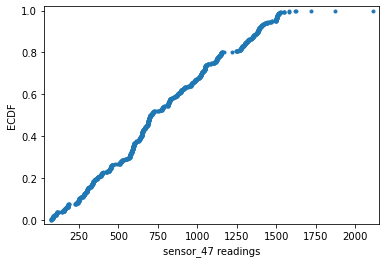

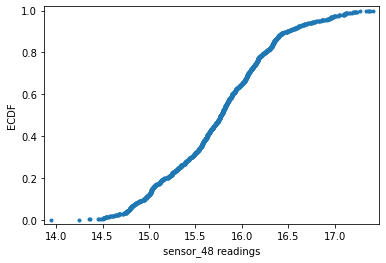

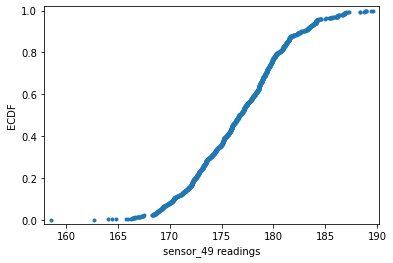

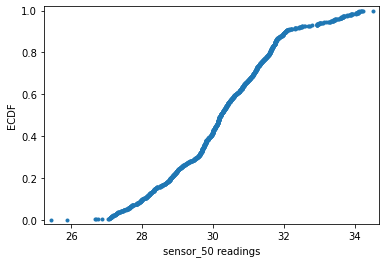

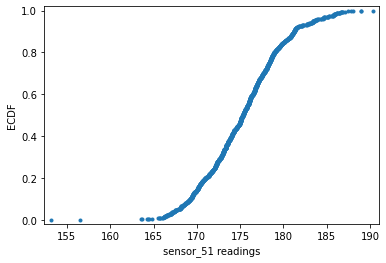

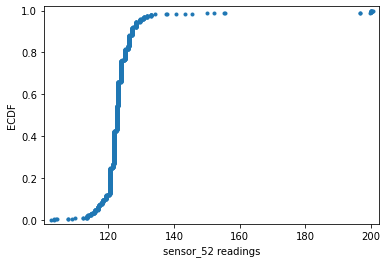

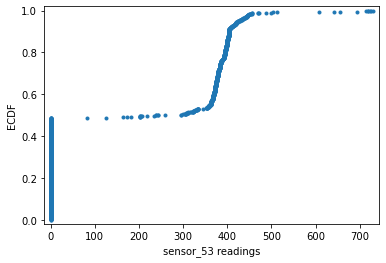

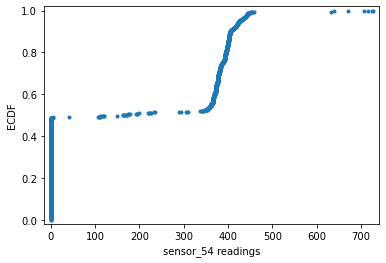

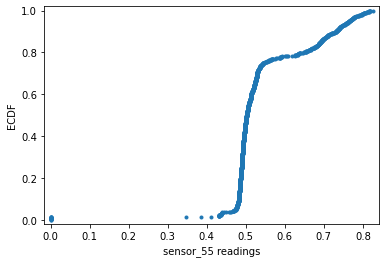

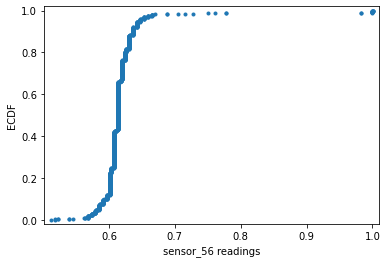

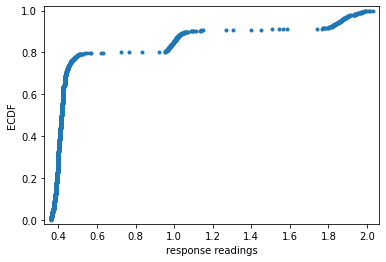

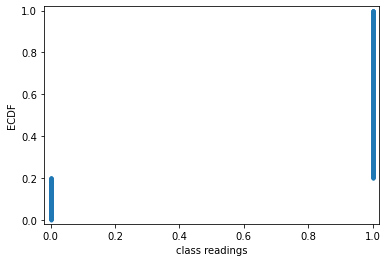

In [11]:
#ECDF plots
for n in data.columns:
    x = np.sort(data[n])
    y = np.arange(1, len(x)+1) / len(x)
    x_ecdf = plt.plot(x, y, marker='.', linestyle='none')
    plt.xlabel('%s readings' %n)
    plt.ylabel('ECDF')
    plt.margins(0.02)
    plt.show()